Testing the new windowed weekly sampling approach. This will also include parallelization 

In [1]:
# import packages
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as stats

from tqdm.auto import tqdm
from matplotlib import style

In [2]:
import datetime

In [3]:
sys.path.append('../../ab_testing_utils/')

In [4]:
import skewed_metric_utils

In [5]:
from typing import Union
from importlib import reload

In [6]:
# additional imports
import statsmodels.api as sm
# import multiprocessing
import multiprocess #ipython weirdness

In [7]:
# pandas preferences
pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

In [8]:
# set plot style
style.use('fivethirtyeight')

In [9]:
# initialize tqdm for pandas
tqdm.pandas()

In [10]:
df = pd.read_csv('../../../data/simulated_skewed_data_20240327a.csv')

In [11]:
df.head()

,Unnamed: 0,day,units,date,outcome,is_dropout
0,0,0,1,2023-01-01,0.0,1
1,7783,0,1,2023-01-01,0.0,0
2,7784,0,1,2023-01-01,0.0,0
3,7785,0,1,2023-01-01,0.0,1
4,7786,0,1,2023-01-01,0.0,0


In [12]:
df = df.drop('Unnamed: 0', axis=1)

In [13]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [14]:
df['date'].describe()

count                 1830611
unique                    183
top       2023-04-22 00:00:00
freq                    10241
first     2023-01-01 00:00:00
last      2023-07-02 00:00:00
Name: date, dtype: object

In [15]:
# df.loc[(df['date'] >= pd.to_datetime(end_date, infer_datetime_format=True))]

In [122]:
# We need some constants
min_weeks = 4
max_weeks = 5
start_date = '2023-01-01'
end_date = '2023-07-02'
sample_method = 'windowed_weekly_sample'
# sample_method = 'simple'
expected_4_week_sample_size = None
date_column = 'date'
test_statistic = {'function': 'difference_in_means', 'params': None}
outcome_column_name = 'outcome'
num_permutations = 1000
sample_with_replacement = True
use_multiprocessing = False

In [132]:
reload(skewed_metric_utils)

<module 'skewed_metric_utils' from '/Users/danielokeeffe/Documents/src_dan/stats_utils/notebooks/scratch_work/../../ab_testing_utils/skewed_metric_utils.py'>

In [123]:
ri_1 = skewed_metric_utils.RandomizationInference()

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

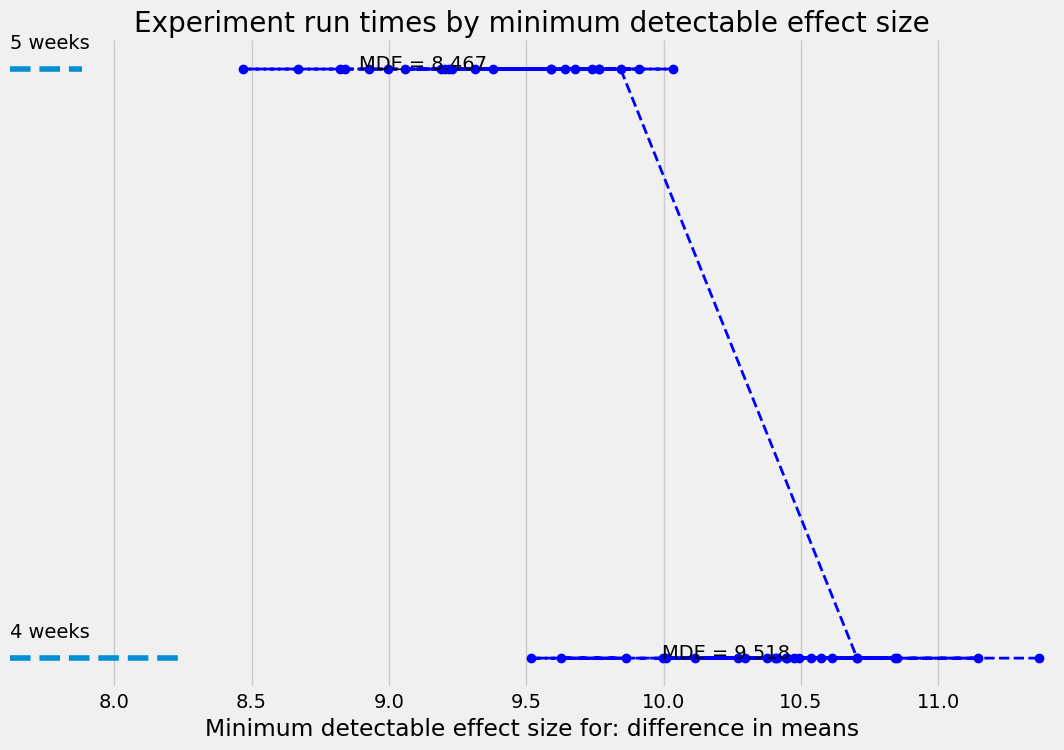

In [124]:
# This will take hours
df_mde_1 = ri_1.power_calculation(df=df, 
                                  use_multiprocessing=use_multiprocessing,
                                  min_weeks=min_weeks, 
                                  max_weeks=max_weeks, 
                                  start_date=start_date, 
                                  expected_4_week_sample_size=expected_4_week_sample_size,
                                  end_date=end_date, 
                                  sample_method=sample_method, 
                                  date_column=date_column, 
                                  test_statistic=test_statistic, 
                                  outcome_column_name=outcome_column_name, 
                                  sample_with_replacement=sample_with_replacement, 
                                  num_permutations=num_permutations)

In [136]:
min_weeks = 4
max_weeks = 5
start_date = '2023-01-01'
# start_date = '2023-05-01'
end_date = '2023-07-02'
sample_method = 'windowed_weekly_sample'
# sample_method = 'simple'
expected_4_week_sample_size = None
date_column = 'date'
test_statistic = {'function': 'difference_in_means', 'params': None}
outcome_column_name = 'outcome'
num_permutations = 10000
sample_with_replacement = True
use_multiprocessing = True

In [137]:
ri_2 = skewed_metric_utils.RandomizationInference()

In [ ]:
# This is not any fast
df_mde_2 = ri_2.power_calculation(df=df, 
                                  use_multiprocessing=use_multiprocessing,
                                  min_weeks=min_weeks, 
                                  max_weeks=max_weeks, 
                                  start_date=start_date, 
                                  expected_4_week_sample_size=expected_4_week_sample_size,
                                  end_date=end_date, 
                                  sample_method=sample_method, 
                                  date_column=date_column, 
                                  test_statistic=test_statistic, 
                                  outcome_column_name=outcome_column_name, 
                                  sample_with_replacement=sample_with_replacement, 
                                  num_permutations=num_permutations)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
# No substantial speed up 

In [33]:
# Ok so this is unimpressive. It's super slow
df_mde_1.head()

,weeks,days,total_sample_size,mde,critical_point,simulated_effect_size_beta_percentile,null_median,null_mean,null_ci_low,null_ci_high
0,2,14,150175,14.894381,10.784834,-4.109547,-0.059347,0.084488,-10.332471,10.784834
1,2,14,150451,16.686020,11.761400,-4.924620,0.068677,-0.031544,-11.074309,11.761400
2,2,14,149875,14.034114,9.785437,-4.248677,0.168478,0.128608,-10.240034,9.785437
3,2,14,149996,13.865131,9.197125,-4.668006,-0.229713,-0.322505,-11.118751,9.197125
4,2,14,150007,14.198467,10.288440,-3.910026,0.310123,0.346838,-9.811929,10.288440


In [35]:
df_mde_1[['weeks', 'mde']].groupby('weeks').max()

,mde
weeks,
2,16.686020
3,13.087897
4,11.175155


In [36]:
# This is probably a sample size issue
df_mde_1['null_median'].describe()

count    75.000000
mean      0.008162
std       0.177351
min      -0.366013
25%      -0.092197
50%      -0.012881
75%       0.125762
max       0.461129
Name: null_median, dtype: float64

In [135]:
# I'm not sure why this isn't working...step through this one line at a time...sigh
if sample_method == 'simple':
    num_historical_units = df.shape[0]
    expected_weekly_sample_size = expected_4_week_sample_size / 4

    assert expected_weekly_sample_size * min_weeks < num_historical_units, "Insufficient historical data for a minimum runtime of {0} weeks".format(min_weeks)
    assert expected_weekly_sample_size * max_weeks <= num_historical_units, "Insufficient historical data for a maximum runtime of {0} weeks".format(max_weeks)
elif sample_method == 'weekly':
    # TODO: Add additional check for weekly sampling method
    expected_weekly_sample_size = None
else:
    expected_weekly_sample_size = None
    end_date = pd.to_datetime(end_date, infer_datetime_format=True)
    start_date = pd.to_datetime(start_date, infer_datetime_format=True)
    assert start_date is not None, "start_date must be specified in order to use the windowed_weekly_sample method"
    assert end_date is not None, "end_date must be specified in order to use the windowed_weekly_sample_method"
    assert start_date + datetime.timedelta(weeks=max_weeks) <= end_date, "{0} and {1} do not provide enough time to accommodate a maximum number of weeks {2}".format(start_date, end_date, max_weeks)
    week_ranges = pd.date_range(start=start_date, end=end_date, freq='1W')

In [136]:
week_ranges

DatetimeIndex(['2023-01-01', '2023-01-08', '2023-01-15', '2023-01-22',
               '2023-01-29', '2023-02-05', '2023-02-12', '2023-02-19',
               '2023-02-26', '2023-03-05', '2023-03-12', '2023-03-19',
               '2023-03-26', '2023-04-02', '2023-04-09', '2023-04-16',
               '2023-04-23', '2023-04-30', '2023-05-07', '2023-05-14',
               '2023-05-21', '2023-05-28', '2023-06-04', '2023-06-11',
               '2023-06-18', '2023-06-25', '2023-07-02'],
              dtype='datetime64[ns]', freq='W-SUN')

In [137]:
df_ = df.copy()

In [138]:
if type(test_statistic['function']) == str:
    test_stat_name = test_statistic['function'].replace('_', ' ')
else:
    test_stat_name = 'custom test statistic'

In [139]:
sharp_null_type='additive'
sharp_null_value=0

In [140]:
df_ = ri_1.sharp_null(df_=df_, sharp_null_type=sharp_null_type, sharp_null_value=sharp_null_value, outcome_column_name=outcome_column_name)

In [141]:
def ri_test_statistic_difference_in_means(df: pd.DataFrame, outcome_col: str, treatment_col: str, treatment_name: str, control_name: str) -> float:
    """
    Helper function to calculate the difference in means between two groups (treatment and control). Each row of the input is meant to represent the assignment and outcome of a
    single individual.

    :param df: DataFrame with the outcome variable and treatment assignments. This assumes only two variants.
    :param outcome_col: The name of the column containing the outcome
    :param treatment_col: Name of the column containing the treatment assignments
    :param treatment_name: Name of the treatment variant contained in the treatment_col column
    :param control_name: Name of the control variant contained in the treatment_col column

    :return: Difference in means
    """

    sdo = df.query("{0}==@treatment_name".format(treatment_col))[outcome_col].mean(numeric_only=True) - df.query("{0}==@control_name".format(treatment_col))[
        outcome_col].mean(numeric_only=True)

    return sdo

In [142]:
test_statistic_function = ri_1.select_test_statistic(test_statistic=test_statistic)

In [143]:
effect_size_dict = {'weeks': [],
                    'days': [],
                    'total_sample_size': [],
                    'mde': [],
                    'critical_point': [],
                    'simulated_effect_size_beta_percentile': [],
                    'null_median': [],
                    'null_mean': [],
                    'null_ci_low': [],
                    'null_ci_high': []}

In [144]:
for weeks_ in tqdm(range(min_weeks, max_weeks + 1)):
    print(weeks_)

  0%|          | 0/3 [00:00<?, ?it/s]

2
3
4


In [145]:
# So keep it simple
weeks_ = 2

In [146]:
date_tuples = [(d, d + datetime.timedelta(weeks=weeks_)) for d in week_ranges if d + datetime.timedelta(weeks=weeks_) <= end_date]

In [147]:
date_tuples

[(Timestamp('2023-01-01 00:00:00', freq='W-SUN'),
  Timestamp('2023-01-15 00:00:00', freq='W-SUN')),
 (Timestamp('2023-01-08 00:00:00', freq='W-SUN'),
  Timestamp('2023-01-22 00:00:00', freq='W-SUN')),
 (Timestamp('2023-01-15 00:00:00', freq='W-SUN'),
  Timestamp('2023-01-29 00:00:00', freq='W-SUN')),
 (Timestamp('2023-01-22 00:00:00', freq='W-SUN'),
  Timestamp('2023-02-05 00:00:00', freq='W-SUN')),
 (Timestamp('2023-01-29 00:00:00', freq='W-SUN'),
  Timestamp('2023-02-12 00:00:00', freq='W-SUN')),
 (Timestamp('2023-02-05 00:00:00', freq='W-SUN'),
  Timestamp('2023-02-19 00:00:00', freq='W-SUN')),
 (Timestamp('2023-02-12 00:00:00', freq='W-SUN'),
  Timestamp('2023-02-26 00:00:00', freq='W-SUN')),
 (Timestamp('2023-02-19 00:00:00', freq='W-SUN'),
  Timestamp('2023-03-05 00:00:00', freq='W-SUN')),
 (Timestamp('2023-02-26 00:00:00', freq='W-SUN'),
  Timestamp('2023-03-12 00:00:00', freq='W-SUN')),
 (Timestamp('2023-03-05 00:00:00', freq='W-SUN'),
  Timestamp('2023-03-19 00:00:00', freq='

In [148]:
date_tuple = date_tuples[0]

In [149]:
date_tuple

(Timestamp('2023-01-01 00:00:00', freq='W-SUN'),
 Timestamp('2023-01-15 00:00:00', freq='W-SUN'))

In [150]:
from functools import partial
from collections import namedtuple, ChainMap

In [151]:
alternative = 'two-sided'
alpha = 0.05
power = 0.8

In [152]:
if sample_method == 'simple':
    num_to_sample = int(weeks * expected_weekly_sample_size)
    df_sample = df_.sample(num_to_sample)
elif sample_method == 'weekly':
    assert date_column is not None, "weekly sampling method requires a date column"
    end_date = df[date_column].max()
    start_date = end_date - datetime.timedelta(weeks=weeks)
    df_sample = df_.loc[(df_[date_column] <= end_date) & (df_[date_column] >= start_date)]
    num_to_sample = df_sample.shape[0]
else:
    # This is the windowed_weekly_sample methodology
    df_sample = df_.loc[(df_[date_column] >= date_tuple[0]) & (df_[date_column] <= date_tuple[1])]
    num_to_sample = df_sample.shape[0]

# define return type
fields = ['weeks',
          'days',
          'total_sample_size',
          'mde',
          'critical_point',
          'simulated_effect_size_beta_percentile',
          'null_mean',
          'null_median',
          'null_ci_low',
          'null_ci_high']
mde_nt = namedtuple('mde', fields)

# Determine the desired level of significance
if alternative == 'two-sided':
    q_significance = 1 - alpha/2
else:
    q_significance = 1 - alpha

In [153]:
df_sample.head()

,day,units,date,outcome,is_dropout,outcome_sharp_null
0,0,1,2023-01-01,0.0,1,0.0
1,0,1,2023-01-01,0.0,0,0.0
2,0,1,2023-01-01,0.0,0,0.0
3,0,1,2023-01-01,0.0,1,0.0
4,0,1,2023-01-01,0.0,0,0.0


In [154]:
arg_dict = {'df_': df_sample
            ,
                                  'test_statistic_function': test_statistic_function,
                                  'treatment_assignment_probability': 0.5,
                                  'sample_with_replacement': sample_with_replacement}

In [155]:
arg_dict_2 = {'df_': df_sample,
                                  'test_statistic_function': test_statistic_function,
                                  'treatment_assignment_probability': 0.5,
                                  'sample_with_replacement': sample_with_replacement, 'num_perms': 2}

In [156]:
arg_dict['treatment_assignment_probability']

0.5

In [157]:
ri_1.run_randomization_inference(df_=df_sample, test_statistic_function=test_statistic_function, treatment_assignment_probability=0.5, sample_with_replacement=sample_with_replacement, num_perms=2)

0.5
<class 'float'>
Number of distinct assignment combinations practically too large. Running 2 simulated permutations


  0%|          | 0/2 [00:00<?, ?it/s]

{0: 4.222415256, 1: -6.4025385996}

In [172]:
ri_1.run_randomization_inference(**arg_dict_2)

treatment_assignment_probability
<class 'str'>


TypeError: '<' not supported between instances of 'int' and 'str'

In [159]:
wtf_ = partial(ri_1.run_randomization_inference, **arg_dict)

In [160]:
# ri_1.run_randomization_inference(**arg_dict_2)

In [161]:
wtf_(num_perms=1)

0.5
<class 'float'>
Number of distinct assignment combinations practically too large. Running 1 simulated permutations


  0%|          | 0/1 [00:00<?, ?it/s]

{0: 3.7697183528}

In [165]:
# list(range(num_permutations))

In [175]:
with multiprocess.Pool(processes=multiprocess.cpu_count()) as pool:
    # func_ = partial(ri_1.run_randomization_inference, **{'df_': df_sample,
    #                               'test_statistic_function': test_statistic_function,
    #                               'treatment_assignment_probability': 0.5,
    #                               'sample_with_replacement': sample_with_replacement})
    func_ = partial(ri_1.run_randomization_inference, **arg_dict)
    res_object = pool.imap(func_, list(range(num_permutations)))
    # print(res_object)
    res_vals = list(res_object)

Number of distinct assignment combinations practically too large. Running 0 simulated permutations
Number of distinct assignment combinations practically too large. Running 1 simulated permutationsNumber of distinct assignment combinations practically too large. Running 2 simulated permutations

Number of distinct assignment combinations practically too large. Running 3 simulated permutations
Number of distinct assignment combinations practically too large. Running 5 simulated permutations


0it [00:00, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 6 simulated permutations


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 4 simulated permutations


  0%|          | 0/4 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 7 simulated permutations


  0%|          | 0/7 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 8 simulated permutations
Number of distinct assignment combinations practically too large. Running 12 simulated permutations
Number of distinct assignment combinations practically too large. Running 9 simulated permutations
Number of distinct assignment combinations practically too large. Running 10 simulated permutations


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 11 simulated permutations

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 13 simulated permutations
Number of distinct assignment combinations practically too large. Running 14 simulated permutations


  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 15 simulated permutations


  0%|          | 0/15 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 16 simulated permutations
Number of distinct assignment combinations practically too large. Running 18 simulated permutations
Number of distinct assignment combinations practically too large. Running 17 simulated permutations


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 20 simulated permutations
Number of distinct assignment combinations practically too large. Running 19 simulated permutations


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 22 simulated permutations
Number of distinct assignment combinations practically too large. Running 21 simulated permutations


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 23 simulated permutations


  0%|          | 0/23 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 26 simulated permutations
Number of distinct assignment combinations practically too large. Running 24 simulated permutations


  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 25 simulated permutations
Number of distinct assignment combinations practically too large. Running 27 simulated permutations


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 28 simulated permutations


  0%|          | 0/28 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 29 simulated permutations
Number of distinct assignment combinations practically too large. Running 30 simulated permutations
Number of distinct assignment combinations practically too large. Running 31 simulated permutations

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 35 simulated permutationsNumber of distinct assignment combinations practically too large. Running 36 simulated permutations

Number of distinct assignment combinations practically too large. Running 34 simulated permutationsNumber of distinct assignment combinations practically too large. Running 32 simulated permutations



  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 33 simulated permutations
Number of distinct assignment combinations practically too large. Running 37 simulated permutations


  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 38 simulated permutations


  0%|          | 0/38 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 39 simulated permutations


  0%|          | 0/39 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 42 simulated permutations
Number of distinct assignment combinations practically too large. Running 41 simulated permutations
Number of distinct assignment combinations practically too large. Running 40 simulated permutations


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 44 simulated permutations


  0%|          | 0/44 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 43 simulated permutations


  0%|          | 0/43 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 45 simulated permutations


  0%|          | 0/45 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 46 simulated permutations


  0%|          | 0/46 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 47 simulated permutations


  0%|          | 0/47 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 50 simulated permutations
Number of distinct assignment combinations practically too large. Running 48 simulated permutations
Number of distinct assignment combinations practically too large. Running 49 simulated permutations


  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 51 simulated permutations
Number of distinct assignment combinations practically too large. Running 52 simulated permutations


  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 53 simulated permutations


  0%|          | 0/53 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 54 simulated permutations


  0%|          | 0/54 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 55 simulated permutations


  0%|          | 0/55 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 56 simulated permutations
Number of distinct assignment combinations practically too large. Running 57 simulated permutations


  0%|          | 0/56 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 58 simulated permutations


  0%|          | 0/58 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 59 simulated permutations


  0%|          | 0/59 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 60 simulated permutations


  0%|          | 0/60 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 61 simulated permutations


  0%|          | 0/61 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 62 simulated permutations


  0%|          | 0/62 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 63 simulated permutations


  0%|          | 0/63 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 64 simulated permutations


  0%|          | 0/64 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 65 simulated permutations


  0%|          | 0/65 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 66 simulated permutations


  0%|          | 0/66 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 68 simulated permutations
Number of distinct assignment combinations practically too large. Running 67 simulated permutations


  0%|          | 0/68 [00:00<?, ?it/s]

  0%|          | 0/67 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 69 simulated permutations


  0%|          | 0/69 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 70 simulated permutations


  0%|          | 0/70 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 71 simulated permutations


  0%|          | 0/71 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 72 simulated permutations


  0%|          | 0/72 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 74 simulated permutations
Number of distinct assignment combinations practically too large. Running 73 simulated permutations


  0%|          | 0/74 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 75 simulated permutations


  0%|          | 0/75 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 76 simulated permutations


  0%|          | 0/76 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 77 simulated permutations


  0%|          | 0/77 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 78 simulated permutations


  0%|          | 0/78 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 79 simulated permutations


  0%|          | 0/79 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 80 simulated permutations
Number of distinct assignment combinations practically too large. Running 81 simulated permutations

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 82 simulated permutations


  0%|          | 0/82 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 83 simulated permutations


  0%|          | 0/83 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 84 simulated permutations


  0%|          | 0/84 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 86 simulated permutations
Number of distinct assignment combinations practically too large. Running 85 simulated permutations


  0%|          | 0/86 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 87 simulated permutations


  0%|          | 0/87 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 89 simulated permutations


  0%|          | 0/89 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 88 simulated permutations
Number of distinct assignment combinations practically too large. Running 90 simulated permutations


  0%|          | 0/88 [00:00<?, ?it/s]

  0%|          | 0/90 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 91 simulated permutations


  0%|          | 0/91 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 92 simulated permutations


  0%|          | 0/92 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 94 simulated permutations
Number of distinct assignment combinations practically too large. Running 93 simulated permutations


  0%|          | 0/94 [00:00<?, ?it/s]

  0%|          | 0/93 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 95 simulated permutations


  0%|          | 0/95 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 96 simulated permutations


  0%|          | 0/96 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 97 simulated permutations
Number of distinct assignment combinations practically too large. Running 98 simulated permutations


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/98 [00:00<?, ?it/s]

Number of distinct assignment combinations practically too large. Running 99 simulated permutations


  0%|          | 0/99 [00:00<?, ?it/s]

In [178]:
sim_dict = dict(ChainMap(*res_vals))

In [179]:
sim_dict

{0: 8.4246201808,
 1: 5.5916056998,
 2: 1.7822437512,
 3: 4.5584281049,
 4: -4.1220582063,
 5: -0.3992215615,
 6: 2.6518268806,
 7: 2.2356863475,
 8: 1.5234134074,
 9: -2.2217767406,
 10: -6.4746536116,
 11: 2.3559794877,
 12: 10.8690044989,
 13: 4.5436844433,
 14: -3.5394973357,
 15: -8.384766766,
 16: -5.076882556,
 17: 7.1402591503,
 18: 0.8902870385,
 19: 5.1959202907,
 20: 4.1585964777,
 21: -2.272961433,
 22: -5.4792052759,
 23: 4.2178680927,
 24: 2.086103032,
 25: -1.0057101469,
 26: 11.5763667475,
 27: 3.444981975,
 28: 3.0101561624,
 29: 0.9590780351,
 30: 0.2826809089,
 31: 2.637683749,
 32: 8.2425553907,
 33: 1.7094957902,
 34: 0.2139975746,
 35: 2.2283177486,
 36: -1.5430428429,
 37: 4.4029936203,
 38: -4.277483487,
 39: 2.7791543689,
 40: 11.3656834875,
 41: -0.9550760994,
 42: -10.4530516777,
 43: 7.7173173951,
 44: -0.2933062631,
 45: 9.4137736673,
 46: -2.5811873614,
 47: -1.2000107012,
 48: 5.9581025002,
 49: 1.9647813763,
 50: 1.324148518,
 51: 0.7385976731,
 52: -2.5

In [168]:
func_(num_perms=1)

0.5
<class 'float'>
Number of distinct assignment combinations practically too large. Running 1 simulated permutations


  0%|          | 0/1 [00:00<?, ?it/s]

{0: -3.8673990957}

In [106]:
res_object.next()

KeyboardInterrupt: 

In [54]:
%timeit for i in range(10000): stats.binom.rvs(n=1, p=0.5, size=200000)

33.7 s ± 190 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit for i in range(10000): np.random.binomial(n=1, p=0.5, size=200000)

31.5 s ± 30.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit for i in range(100): np.random.multinomial(n=1, pvals=[0.5], size=200000)

70.7 ms ± 543 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
test_ = np.random.multinomial(n=20, pvals=[0.5], size=1)

In [51]:
test_

array([[20]])

In [73]:
%%time
for i in range(10000): 
    stats.binom.rvs(n=1, p=0.5, size=200000)

CPU times: user 32.7 s, sys: 602 ms, total: 33.4 s
Wall time: 33.5 s


In [74]:
%%time
for i in range(10000):
    test_mn = np.random.multinomial(n=200000, pvals=[0.5, 0.5])
    assignments_ = [0]*test_mn[0] + [1]*test_mn[1]
    np.random.shuffle(assignments_)

CPU times: user 47.9 s, sys: 282 ms, total: 48.2 s
Wall time: 48.7 s


In [77]:
%%time
for i in range(10000):
    np.random.choice([0, 1], size=(200000,), p=[0.5, 0.5])

CPU times: user 40.9 s, sys: 1.1 s, total: 42 s
Wall time: 42.2 s


In [68]:
len(assignments_)

200000

In [84]:
from collections import ChainMap

In [81]:
def run_assignment_test(iteration_):
    assignment_list = stats.binom.rvs(n=1, p=0.5, size=200000)
    return {iteration_: assignment_list}

In [82]:
# This was crazy fast
with multiprocess.Pool(processes=multiprocess.cpu_count()) as pool:
    res_object = tqdm(pool.imap(run_assignment_test, list(range(10000))), total=10000, mininterval=1)
    res_vals = list(res_object)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [85]:
res_dict = dict(ChainMap(*res_vals))

In [86]:
res_dict[0]

array([0, 0, 1, ..., 1, 1, 0])